<a href="https://www.kaggle.com/code/sgjustino/filtered-chess-constellation?scriptVersionId=157404918" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Chess Constellation

In [1]:
# libraries

import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

In [2]:
chess_data = pd.read_csv('/kaggle/input/chess/games.csv')
print(chess_data.head())

print(chess_data.info())

         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_e

Each row represents a single game and includes:
* id: Game ID
* rated: Whether the game is rated (True/False)
* created_at: Timestamp for when the game was created
* last_move_at: Timestamp for the last move
* turns: Number of turns in the game
* victory_status: How the game ended (e.g., 'resign', 'mate', 'outoftime')
* winner: The winner of the game ('white'/'black')
* increment_code: Time increment per move
* white_id: ID of the white player
* white_rating: Rating of the white player
* black_id: ID of the black player
* black_rating: Rating of the black player
* moves: All moves of the game in standard chess notation
* opening_eco: ECO code for the opening used
* opening_name: Name of the opening
* opening_ply: Number of moves in the opening phase

Note: 
* Game ID: Every game on lichess.org has an ID. Adding the game ID after lichess.org/ would lead you to the actual game for better visualization of the game
* White & Black Ratings: Lichess rates its player with integer values; The higher the rating, the more skillful a player is.
* Opening ECO: The first moves in a chess game are called "the opening phase" which typically shapes the game (aggressive, positional). Opening examples: Ruy Lopez, Sicilian Defence, The English, The Queen's Gambit. Ref: the Encyclopaedia of Chess Openings (ECO).
* Opening ply is the number of plies that follows masters' chess theory before deviating into the not-so-well-explored moves. A ply is 1/2 of a move. e.g. (1. d4 d5 is a move and has 2 plies, but 1.d4 is only 1 ply)

# Simple EDA

In [3]:
# Calculate the average number of turns for false rated games
average_turns_false_rated = chess_data[chess_data['rated'] == False]['turns'].mean()

# Calculate the average number of turns for true rated games
average_turns_true_rated = chess_data[chess_data['rated'] == True]['turns'].mean()

# Print the results
print(f"Average number of turns in unrated (False) games: {average_turns_false_rated}")
print(f"Average number of turns in rated (True) games: {average_turns_true_rated}")

Average number of turns in unrated (False) games: 54.27158595951832
Average number of turns in rated (True) games: 61.96255029402662


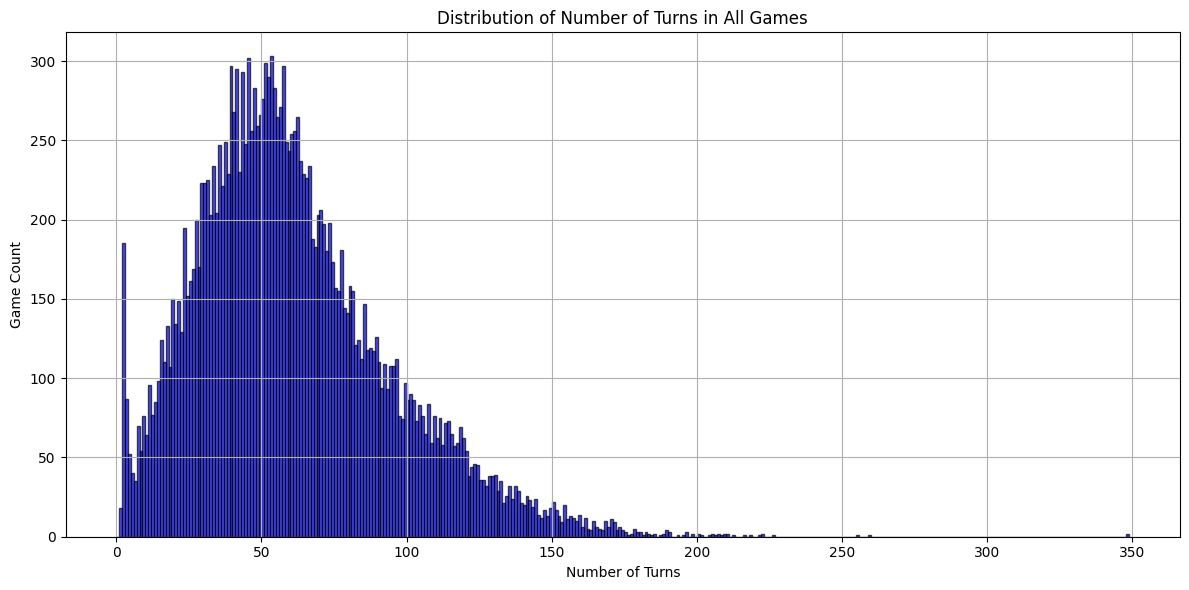

In [4]:
# Plot the distribution of the number of turns for all games
plt.figure(figsize=(12, 6))
plt.hist(chess_data['turns'], bins=range(0, chess_data['turns'].max() + 1), alpha=0.7, color='blue', edgecolor='black')

# Add titles and labels
plt.title('Distribution of Number of Turns in All Games')
plt.xlabel('Number of Turns')
plt.ylabel('Game Count')

# Show the plot with a grid
plt.grid(True)
plt.tight_layout()
plt.show()

Quite a number of games that have very little turns and very high turns. Low turn games are usually invalid games and high turn games may present signs of cheating or manipulation to raise ratings. As this is an online game, turns below 10 and above 200 are removed.

In [5]:
# Define the minimum and maximum number of turns for a game to be considered valid
min_turns = 10
max_turns = 200

# Filter out games with turns less than the minimum or greater than the maximum
valid_chess_data = chess_data[(chess_data['turns'] >= min_turns) & (chess_data['turns'] <= max_turns)]

In [6]:
print(valid_chess_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 19418 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              19418 non-null  object 
 1   rated           19418 non-null  bool   
 2   created_at      19418 non-null  float64
 3   last_move_at    19418 non-null  float64
 4   turns           19418 non-null  int64  
 5   victory_status  19418 non-null  object 
 6   winner          19418 non-null  object 
 7   increment_code  19418 non-null  object 
 8   white_id        19418 non-null  object 
 9   white_rating    19418 non-null  int64  
 10  black_id        19418 non-null  object 
 11  black_rating    19418 non-null  int64  
 12  moves           19418 non-null  object 
 13  opening_eco     19418 non-null  object 
 14  opening_name    19418 non-null  object 
 15  opening_ply     19418 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.4+ MB
None


# Selection of Constellation Size

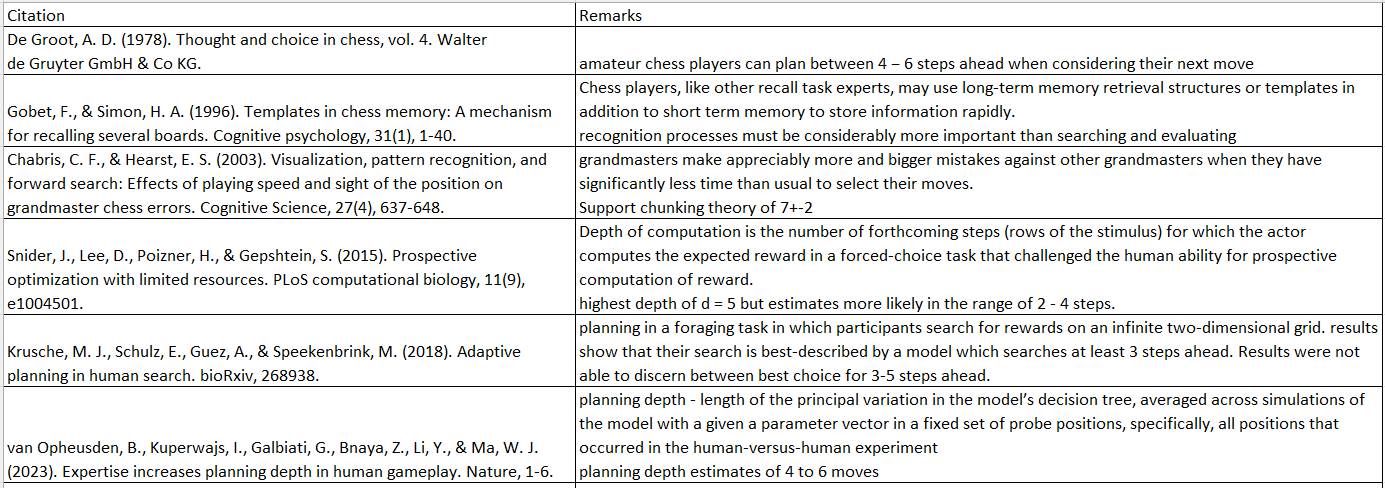

The brief lit review above provides some insights on the constellation size selection:
* Chess players are likely to use pattern recognition and search/evaluating cognitive processes in planning their moves.
* Earlier research on chess players suggest that players typically plan a range of 4-6 steps ahead. Such hypotheses also gel well with STM memory theories like chunking size of 7+-2.
* New emerging studies that utilise computational modeling (e.g. Decision Tree and Heuristic Monte Carlo search models) across varying planning tasks found that:
    * Max of 5 but likely to be 2-4 steps in a forced-choice task (Snider et al., 2015)
    * At least 3 but likely between 3-5 steps in a foraging task (Krusche et al., 2018)
    * Between 4-6 steps in a generalization of tic-tac-toe (van Opheusden et al., 2023)
    
Since the latest research look across varying planning tasks and utilised computational models to closely emulate planning depth, it makes sense to look at constellation size within that range. As chess players are likely to be more familiar with chess strategies and known openings and positions, we will make a decision to look at the upper limit of these planning depth studies by examining a planning depth of 5. 

First, opponents' moves are included in constellations as we have to factor in their movements as part of the patterns. This seems reasonable as players' patterns or strategies would likely involve assessing and reacting to their opponents' moves. Range of constellations are restricted to odd plys because it ensures that the pattern analysis always ends on the same player's turn, providing a more complete picture of that player's strategy or pattern of moves. By zooming in on a planning depth of 5, this would thus entail the closer examination of constellation size of 9 since that would encompasses 5 plys by a given players with 4 reactions by their opponents.

# Difficulty of Chess Constellations using TF-IDF

In the context of analyzing chess games, we can adapt the concept of Inverse Document Frequency (IDF) from text mining to quantify the difficulty level of specific chess constellations across a dataset of games. The IDF is a statistical measure used to evaluate how significant a particular pattern (in this case, a chess constellation) is throughout all games. The difficulty of chess constellations is defined using a metric akin to inverse document frequency (IDF) from the TF-IDF (Term Frequency-Inverse Document Frequency) weighting. Each game is considered as a "document" and each unique constellation of moves as a "term." The corpus is defined as the collective sum of games in the dataset.

* Term Frequency (TF): The frequency of a particular constellation of moves within a single game (document). First, it is almost not possible for identical moves to happen because patterns often surfaced from existing positions. For example, once a pawn moved, they cannot repeat the pattern. Since we are interested in the difficulty, we will not use TF directly but focus on the inverse.

* Inverse Document Frequency (IDF): A measure of how unique a constellation is across all games (the corpus). A high IDF value for a constellation indicates that it is rare and potentially more difficult.

Modifiers: We enhance the traditional IDF calculation by introducing a modifier that accounts for the average number of turns when the constellation appears. The modified IDF calculation is as follows:

$$\huge IDF(j) = \log \left( \frac{N}{df(j)} \right) \times t(j) $$

where:
- \( N \) is the total number of games, analogous to the total number of documents in a text corpus.
- \( df(j) \) is the document frequency, or the number of games in which the constellation \( j \) appears.
- \( t(j) \) is the average number of turns when the constellation \( j \) appears (based on the 1st ply of the constellation) across all games.

The Role of the Modifier \( t(j) \): The modifier \( t(j) \) adjusts the IDF value based on how early or late in the game the constellation \( j \) typically appears. This factor provides additional context to the IDF score by reflecting the stage of the game at which the constellation is relevant. A constellation that appears early in the game might have a different strategic impact compared to one that tends to appear later.

# Developing Chess Constellation Difficulties

The goal is to analyze sequences of moves, referred to as "constellations," and to understand their frequency, distribution, and difficulty within the dataset. 

1. **Creating Constellations**: The code defines a function `create_constellations` that takes a string of chess moves and a constellation size (number of moves in a sequence) as input. It splits the string into individual moves and creates all possible constellations of the given size.

2. **Calculating and Assessing Usability of Term Frequency**: The `calculate_term_frequency` function uses the `create_constellations` function to generate constellations and then calculates the frequency of each unique constellation within a single game using the `Counter` class. The term frequency calculation is applied to each game's move sequence in the dataset, and the results are stored. 

    2a. **Lack of Relevancy for Term Frequency**: For a game count of >20k, the low frequencies of 14 repeating 9-move constellations within a single document suggest that term frequency may be less relevant for our study.
    
    2b. **Selection based on Cut-off for Constellation Frequency**: When using the full sample of 9-move constellations, the Rasch modeling was unable to proceed with the close to 1 million constellation size (essentially 1 test item per constellation). A selection is done on frequency above 10 to reduce computation load on the rasch model building subsequently on this sample data.

3. **Constellations with Turn Numbers**: A function `create_constellations_with_turn_numbers` is defined to create constellations along with the turn number at which each constellation starts. The code then iterates through all games, recording the turn number for each constellation's occurrence. The average turn number for the start of each constellation is calculated for assignment as a modifier.

    Note: turn number is calculated as i // 2 + 1 because each turn consists of a move by White followed by a move by Black, so dividing the move index by 2 gives the turn index (starting from 0, hence the +1 to start counting turns from 1).

4. **Plotting Constellation Frequencies**: The code prepares data for plotting by counting how many constellations start on each turn number. It then creates a bar plot to visualize the distribution of constellation frequencies across turn numbers.

5. **Calculating Inverse Document Frequency (IDF)**: The code calculates the IDF for each 9-move constellation, which is a measure of how common or rare a constellation is across all games.

6. **Weighted Difficulty Score**: A weighted difficulty score is computed for each constellation by multiplying its IDF by the average turn number at which it starts. This score aims to reflect the difficulty of a constellation based on its rarity and the stage of the game at which it typically occurs.

7. **Plotting Difficulty Scores**: Finally, the code plots the distribution of difficulty scores for all 9-move constellations to visualize how constellation difficulties are distributed across the dataset.

In [7]:
# Function to create constellations of moves
def create_constellations(moves_list, constellation_size):
    moves = moves_list.split()
    constellations = [moves[i:i+constellation_size] for i in range(len(moves)-constellation_size+1)]
    return constellations

# Function to calculate term frequency of constellations in a game
def calculate_term_frequency(moves_list, constellation_size):
    constellations = create_constellations(moves_list, constellation_size)
    return Counter(map(tuple, constellations))

# Apply the function to each game and store the results
term_frequencies = valid_chess_data['moves'].apply(lambda moves: calculate_term_frequency(moves, 9))

# Analyze the results
games_with_repeating_constellations = sum(1 for tf in term_frequencies if any(freq > 1 for freq in tf.values()))
print(f"Number of games with repeating 9-move constellations: {games_with_repeating_constellations}")

Number of games with repeating 9-move constellations: 14


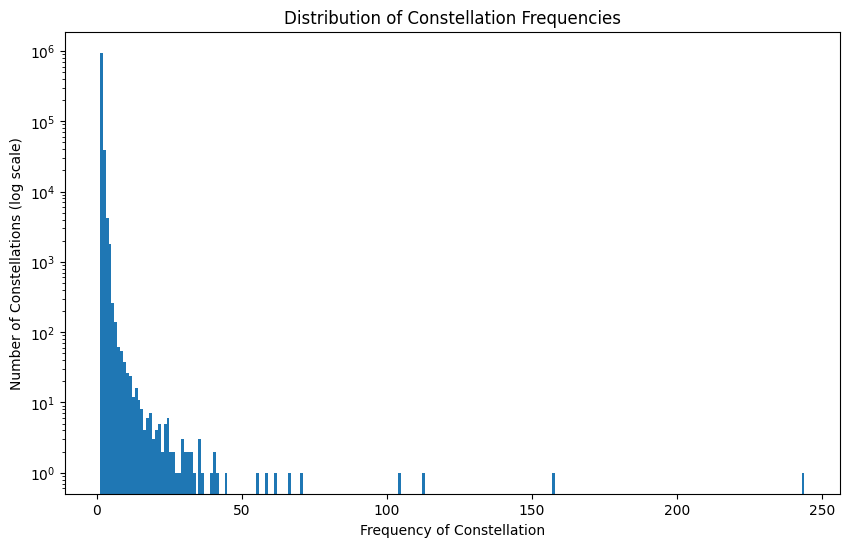

In [8]:
# Flatten the term frequencies from all games into a single Counter
all_term_frequencies = Counter()
for tf in term_frequencies:
    all_term_frequencies.update(tf)

# Convert the term frequencies to a list of frequencies
frequencies = list(all_term_frequencies.values())

# Plot the distribution of frequencies
plt.figure(figsize=(10, 6))
plt.hist(frequencies, bins=range(1, max(frequencies) + 1), log=True)
plt.title('Distribution of Constellation Frequencies')
plt.xlabel('Frequency of Constellation')
plt.ylabel('Number of Constellations (log scale)')
plt.show()

In [9]:
# Convert the term frequencies to a DataFrame
frequency_counts = pd.DataFrame(all_term_frequencies.items(), columns=['Constellation', 'Frequency'])

# Calculate the frequency distribution
frequency_distribution = frequency_counts['Frequency'].value_counts().sort_index()

# Convert the frequency distribution to a DataFrame
frequency_distribution_df = frequency_distribution.reset_index()
frequency_distribution_df.columns = ['Frequency', 'Number of Constellations']

# Display the frequency distribution table
print(frequency_distribution_df)

    Frequency  Number of Constellations
0           1                    944305
1           2                     39214
2           3                      4162
3           4                      1771
4           5                       262
5           6                       141
6           7                        62
7           8                        54
8           9                        37
9          10                        26
10         11                        24
11         12                        12
12         13                        16
13         14                        11
14         15                         8
15         16                         4
16         17                         6
17         18                         7
18         19                         3
19         20                         4
20         21                         5
21         22                         2
22         23                         5
23         24                         6


Using the full list of constellations, it was not possible to run the Rasch model subsequently with close to a million constellations and 15-16k unique player IDs. As such, a filtering is done here to limit constellations to those with frequencies above 5.

In [10]:
# Determine a cutoff frequency
cutoff_frequency = 10

# Filter out constellations below the cutoff frequency
filtered_constellations = {constellation: freq for constellation, freq in all_term_frequencies.items() if freq >= cutoff_frequency}

In [11]:
# Function to create constellations of moves with turn numbers
def create_constellations_with_turn_numbers(moves_list, constellation_size):
    moves = moves_list.split()
    return [(moves[i:i+constellation_size], i // 2 + 1) for i in range(len(moves) - constellation_size + 1)]

# Dictionary to store the turn numbers for each constellation
constellation_turns = defaultdict(list)

# Go through all games and record the turn number for each constellation
for moves in valid_chess_data['moves']:
    for constellation, turn_number in create_constellations_with_turn_numbers(moves, 9):
        # Record the turn number for this constellation
        constellation_turns[tuple(constellation)].append(turn_number)

# Calculate the average turn number for the first ply of each filtered constellation
filtered_average_turn_number_for_constellations = {constellation: np.mean(turn_numbers) for constellation, turn_numbers in constellation_turns.items() if constellation in filtered_constellations}

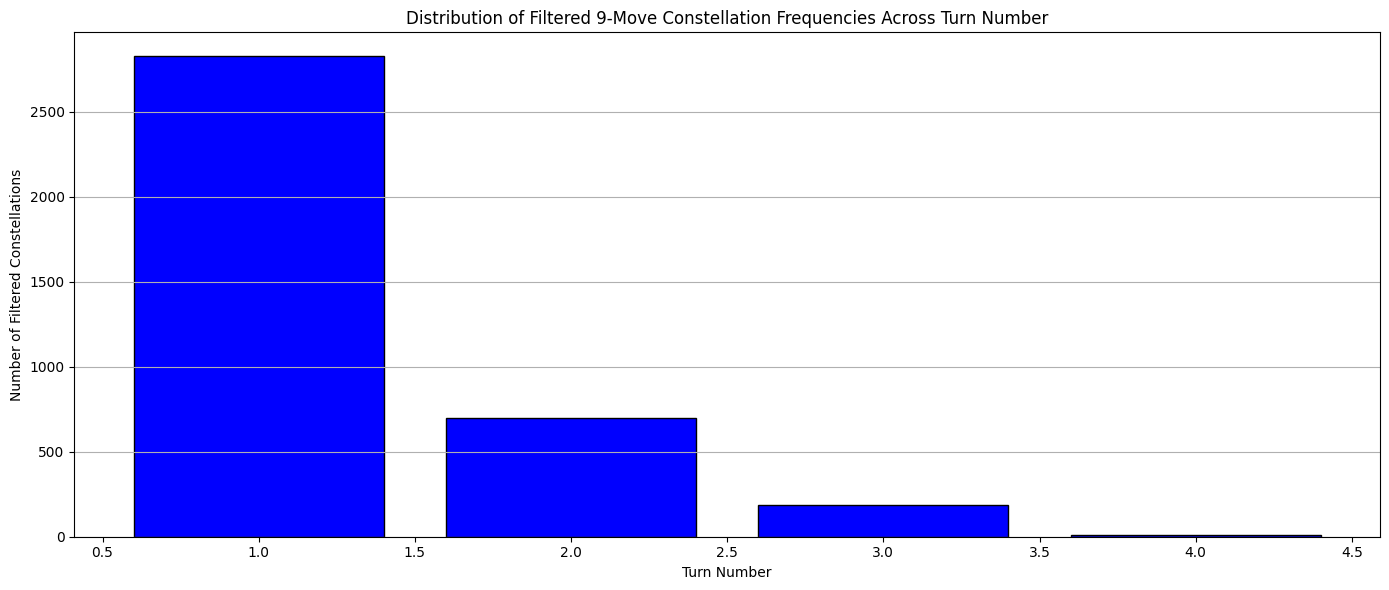

In [12]:
# Flatten the list of all turn numbers where any filtered constellation starts
filtered_all_turn_numbers = [turn for constellation, turns in constellation_turns.items() if constellation in filtered_constellations for turn in turns]

# Count how many filtered constellations start on each turn number
filtered_turn_counts = Counter(filtered_all_turn_numbers)

# Prepare data for plotting
filtered_turns = sorted(filtered_turn_counts.keys())
filtered_frequencies = [filtered_turn_counts[turn] for turn in filtered_turns]

# Plot the distribution of filtered constellation frequencies across turn number
plt.figure(figsize=(14, 6))
plt.bar(filtered_turns, filtered_frequencies, color='blue', edgecolor='black')
plt.title('Distribution of Filtered 9-Move Constellation Frequencies Across Turn Number')
plt.xlabel('Turn Number')
plt.ylabel('Number of Filtered Constellations')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Interesting, most of the high frequency constellations occurred in the first few turns. This suggest that we may consider zooming in on opening plays for constellations.

## Modified IDF with turn number factor

In [13]:
# Calculate IDF for each filtered 9-move constellation
N = len(valid_chess_data)  # Total number of games
filtered_constellation_idf = {constellation: np.log(N / filtered_constellations[constellation]) for constellation in filtered_constellations}

# Combine to compute a weighted difficulty score of idf x average turns at start of the constellation across appearances in all games
filtered_constellation_difficulty = {}
for constellation, idf in filtered_constellation_idf.items():
    average_turn = filtered_average_turn_number_for_constellations.get(constellation)
    if average_turn is not None:  # Ensure that the constellation was found in the turn data
        filtered_constellation_difficulty[constellation] = idf * average_turn

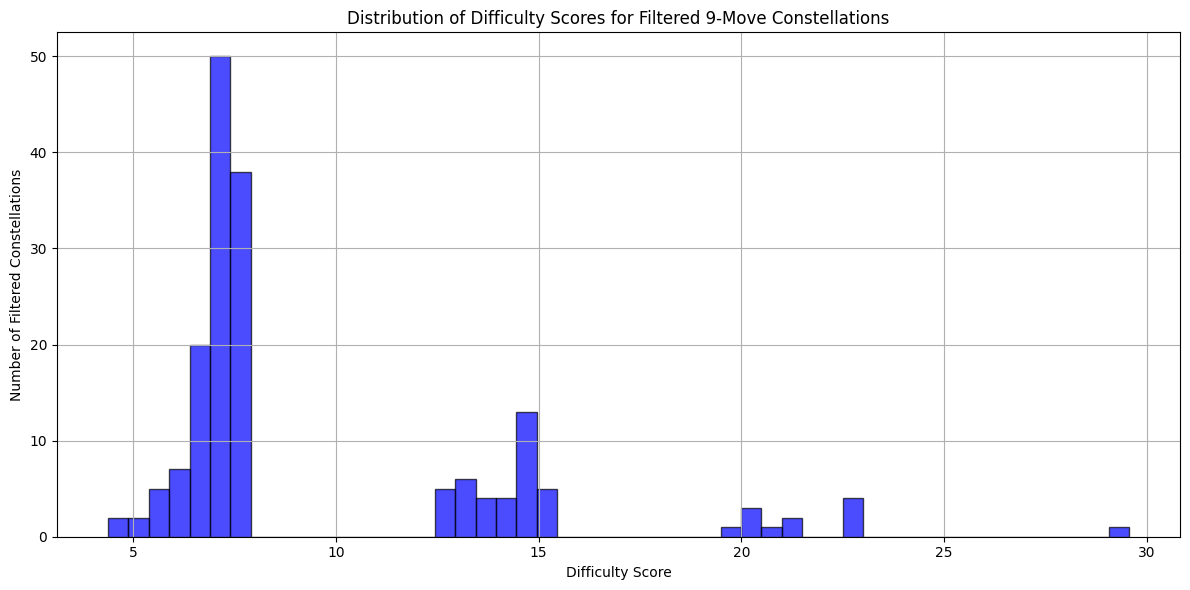

In [14]:
# Extract the difficulty scores for the filtered constellations
filtered_difficulty_scores = list(filtered_constellation_difficulty.values())

# Plotting the distribution of difficulty scores for the filtered constellations
plt.figure(figsize=(12, 6))
plt.hist(filtered_difficulty_scores, bins=50, alpha=0.7, color='blue', edgecolor='black')

# Add titles and labels
plt.title('Distribution of Difficulty Scores for Filtered 9-Move Constellations')
plt.xlabel('Difficulty Score')
plt.ylabel('Number of Filtered Constellations')

# Show the plot with a grid
plt.grid(True)
plt.tight_layout()
plt.show()


# Considerations for modifications to current IDF formulation of constellation difficulty

Some thoughts on future modifications to the current constellation difficulty formulation

* Binning number of turns: Since there are different game phases (opening, middlegame, endgame) in which the constellation occurs, there may be contextual sense to bin them into the phases.

* Opponent's Response Difficulty: Measure the difficulty of a constellation by the quality of the response it elicits from the opponent. May need to utilise the chess engines to evaluate the position after a constellation for its decision quality as a proxy of how challenging it is to play against.

* Winning Rate of Constellations: Analyze the win rate associated with each constellation. A high win rate for a constellation when played could indicate a higher difficulty level, as these moves might be more strategic or less intuitive. This, however, may be too broad with a binary outcome.

* Engine Evaluation Swings: Use chess engines to evaluate the change in position strength before and after a constellation with Average Centipawn Loss. Large swings in evaluation could indicate more dynamic and complex positions. 

* Evaluating Opening Sequences: Examine the characteristics of known opening strategies. Since they would make up the large bulk of the initial phase, they may provide greater insights with their available in-depth research/analysis.

* Zooming in on Opening Strategies: Since most of the high frequency constellations occurred in the first few turns, this suggest that we may consider zooming in on opening plays for constellations.

* Nesting of constellations: I noticed that opening strategies are nested with subsets of the same strategies. For example, Queen's Gambit can be broken down into several variations like Queen's Gambit Declined  or Queen's Gambit Accepted. It may be worthwhile exploring the nested nature of constellations.

# Preparing the data for Rasch Model building

1. **Unique Constellation IDs**: Each unique constellation is assigned a unique identifier (ID). This is done by creating a set of all unique constellations across all games and then mapping each constellation to a unique ID.

2. **Data for Rasch Model**: The code iterates through each game in the dataset, extracting constellations and their associated data, such as the difficulty of the constellation (based on previously calculated values), the player's ID, rating, and performance (win or loss). This information is compiled into a list of dictionaries, with each dictionary representing a single player-constellation interaction.

3. **Dataframe Creation**: The list of dictionaries is then converted into a pandas DataFrame called `data_for_rasch_df`. This DataFrame contains the raw data for each player-constellation interaction, including the unique IDs for players and constellations.

4. **Encoding IDs**: The player IDs are encoded as numeric values using a label encoder to facilitate statistical analysis.

5. **Aggregating Data**: To prepare the data for IRT analysis, the code aggregates the data by player and constellation ID, calculating the mean performance for each player-constellation pair. The mean performance is then rounded to the nearest integer (0 or 1) to create a dichotomous outcome, which is required for the Rasch model.

6. **Saving Data**: The aggregated and rounded data is saved to a CSV file called `irt_data.csv`. This file is used for subsequent IRT analysis in R. Additionally, the original data with additional columns is saved to `data_for_rasch.csv` for further analysis on the correlation analysis between players' ratings, constellation difficulties, and other variables of interest.

    Note: Some duplicates of chess constellations still exist because different players may utilise the same constellation.

In [15]:
# Create a mapping from each unique filtered constellation to a unique ID
filtered_unique_constellation_ids = {constellation: i for i, constellation in enumerate(filtered_constellations)}

# Create the data for the Rasch model using the filtered constellations
data_for_rasch = []
for index, row in valid_chess_data.iterrows():
    moves = row['moves'].split()
    for i in range(len(moves) - 8):
        constellation = tuple(moves[i:i+9])
        if constellation in filtered_constellation_difficulty:  # Check if the constellation meets the cutoff
            unique_id = filtered_unique_constellation_ids[constellation]
            difficulty = filtered_constellation_difficulty[constellation]
            player_id = row['white_id'] if i % 2 == 0 else row['black_id']
            player_rating = row['white_rating'] if i % 2 == 0 else row['black_rating']
            player_performance = 1 if (row['winner'] == 'white' if i % 2 == 0 else row['winner'] == 'black') else 0
            data_for_rasch.append({
                'constellation_str': str(constellation),
                'unique_id': unique_id,
                'difficulty': difficulty,
                'player_id': player_id,
                'player_rating': player_rating,
                'player_performance': player_performance
            })

# Convert the list of dictionaries to a DataFrame
data_for_rasch_df = pd.DataFrame(data_for_rasch)

In [16]:
# Encode player IDs and constellations as numeric IDs
player_encoder = LabelEncoder()
data_for_rasch_df['encoded_player_id'] = player_encoder.fit_transform(data_for_rasch_df['player_id'])
data_for_rasch_df['encoded_constellation_id'] = data_for_rasch_df['unique_id']

# Group by player ID and constellation ID, then calculate the mean performance and round it
grouped_data = data_for_rasch_df.groupby(['encoded_player_id', 'encoded_constellation_id'])
irt_data = grouped_data['player_performance'].mean().reset_index()
irt_data['response'] = np.round(irt_data['player_performance']).astype(int)
irt_data.drop('player_performance', axis=1, inplace=True)

# Save the aggregated and rounded data to CSV for IRT analysis
irt_data.to_csv('irt_data.csv', index=False)

# Save the original data with additional columns for Rasch analysis and correlation analysis
data_for_rasch_df.to_csv('data_for_rasch.csv', index=False)

In [17]:
data_for_rasch_df

,constellation_str,unique_id,difficulty,player_id,player_rating,player_performance,encoded_player_id,encoded_constellation_id
0,"('e4', 'e6', 'd4', 'd5', 'e5', 'c5', 'c3', 'Nc...",0,5.625461,daniel_likes_chess,1381,0,377,0
1,"('e6', 'd4', 'd5', 'e5', 'c5', 'c3', 'Nc6', 'N...",1,6.318608,subham777,1867,1,1483,1
2,"('e4', 'e5', 'Nf3', 'Nc6', 'Bc4', 'Nf6', 'Nc3'...",2,7.040742,shivangithegenius,1094,1,1405,2
3,"('e5', 'Nf3', 'Nc6', 'Bc4', 'Nf6', 'Nc3', 'Bc5...",3,7.309006,sureka_akshat,1141,0,1494,3
4,"('Nf3', 'Nc6', 'Bc4', 'Nf6', 'Nc3', 'Bc5', 'O-...",4,15.142741,shivangithegenius,1094,1,1405,4
...,...,...,...,...,...,...,...,...
3717,"('e4', 'c5', 'Nf3', 'd6', 'd4', 'cxd4', 'Nxd4'...",5,4.376788,ejachess,2049,1,490,5
3718,"('c5', 'Nf3', 'd6', 'd4', 'cxd4', 'Nxd4', 'Nf6...",19,4.817710,lynnpv,1882,0,950,19
3719,"('Nf3', 'd6', 'd4', 'cxd4', 'Nxd4', 'Nf6', 'Nc...",20,12.754896,ejachess,2049,1,490,20
3720,"('d6', 'd4', 'cxd4', 'Nxd4', 'Nf6', 'Nc3', 'a6...",21,13.476923,lynnpv,1882,0,950,21


In [18]:
irt_data

,encoded_player_id,encoded_constellation_id,response
0,0,40,0
1,1,15,0
2,1,17,0
3,2,62,0
4,3,123,0
...,...,...,...
3113,1731,76,1
3114,1731,78,1
3115,1732,129,0
3116,1733,110,1


In [19]:
# Print the number of unique constellations
print("Unique constellations:", len(filtered_unique_constellation_ids))

Unique constellations: 173


In [20]:
unique_responses = data_for_rasch_df['player_performance'].unique()
print("Unique responses:", unique_responses)

Unique responses: [0 1]


In [21]:
missing_values = data_for_rasch_df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 constellation_str           0
unique_id                   0
difficulty                  0
player_id                   0
player_rating               0
player_performance          0
encoded_player_id           0
encoded_constellation_id    0
dtype: int64


Subsequent model building is done on R.